In [185]:
!pip install optuna

In [186]:
# EDA for
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold
import gc

# Metrics
from sklearn.metrics import (
    mean_squared_error
)

from tensorflow.keras.metrics import RootMeanSquaredError

# Models

import keras_tuner
from keras import *
from scikeras.wrappers import KerasRegressor
from keras import Sequential
from keras.layers import (
    Dense, 
    Dropout,
)

from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import (
    cross_val_score, 
    RepeatedKFold,
    train_test_split,
    GridSearchCV,
    KFold,
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from catboost import *

# Any
import warnings
warnings.filterwarnings('ignore')

In [187]:
class CFG:
    TARGET = 'nivel_y'
    N_FOLDS = 20
    RANDOM_STATE = 87


    def dataset_6HZ() -> pd.DataFrame:
        TRAIN_PATH = './data/Stable/Day1/2024_09_02_6hz 19_09-20.csv'
        TRAIN_PATH_AIR = './data/Stable/Day1/2024_09_02_6hz 19_09-20_air.csv'

        TEST_PATH_6HZ = './test/Stable/Day1/2024_09_03_6hz 18_08-19_11.csv'
        TEST_PATH_AIR_6HZ = './test/Stable/Day1/2024_09_03_6hz 18_08-19_11_air.csv'

        train = pd.read_csv(TRAIN_PATH)[:4700].copy()
        train['air_temp'] = pd.read_csv(TRAIN_PATH_AIR)['temperature'][:4700]
        test = pd.read_csv(TEST_PATH_6HZ)[:5700].copy()
        test['air_temp'] = pd.read_csv(TEST_PATH_AIR_6HZ)['temperature'][:5700]

        return train, test
    

    def dataset_3HZ() -> pd.DataFrame:
        TRAIN_PATH_1 = './data/Stable/Day4/2024_09_02_3hz 10_14-11_58_1.csv'
        TRAIN_PATH_2 = './data/Stable/Day4/2024_09_02_3hz 10_14-11_58_2.csv'
        TRAIN_PATH_AIR_1 = './data/Stable/Day4/2024_09_02_3hz 10_14-11_58_2_air.csv'

        TEST_PATH_3HZ_1 = './test/Stable/Day4/2024_09_04_3hz 14_13-15_43_1.csv'
        TEST_PATH_3HZ_2 = './test/Stable/Day4/2024_09_04_3hz 14_13-15_43_2.csv'
        TEST_PATH_AIR_3HZ = './test/Stable/Day4/2024_09_04_3hz 14_13-15_43_air.csv'

        train = pd.concat([pd.read_csv(TRAIN_PATH_1),
                          pd.read_csv(TRAIN_PATH_2)],ignore_index=True)[:8000].copy()
        train['air_temp'] = pd.read_csv(TRAIN_PATH_AIR_1)['temperature'][:8000]
        test = pd.concat([pd.read_csv(TEST_PATH_3HZ_1),
                               pd.read_csv(TEST_PATH_3HZ_2)],ignore_index=True)[:4700].copy()
        test['air_temp'] = pd.read_csv(TEST_PATH_AIR_3HZ)['temperature'][:4700]

        return train, test
    

    def dataset_1HZ() -> pd.DataFrame:
        TRAIN_PATH_1 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_1.csv'
        TRAIN_PATH_AIR_1 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_1_air.csv'
        TRAIN_PATH_2 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_2.csv'
        TRAIN_PATH_AIR_2 = './data/Stable/Day2/2024_09_02_1hz 13_09-14_39_2_air.csv'

        TEST_PATH_1HZ = './test/Stable/Day2/2024_09_03_1hz 16_01-17_35.csv'
        TEST_PATH_AIR_1HZ = './test/Stable/Day2/2024_09_03_1hz 16_01-17_35_air.csv'

        
        train_1 = pd.read_csv(TRAIN_PATH_1).copy()
        train_1['air_temp'] = pd.read_csv(TRAIN_PATH_AIR_1)['temperature']
        train_2 = pd.read_csv(TRAIN_PATH_2).copy()
        train_2['air_temp'] = pd.read_csv(TRAIN_PATH_AIR_2)['temperature']

        train = pd.concat([train_1,train_2],ignore_index=True)
        train = train[:5500]

        test = pd.read_csv(TEST_PATH_1HZ)[:3000].copy()
        test['air_temp'] = pd.read_csv(TEST_PATH_AIR_1HZ)['temperature'][:3000]

        return train, test


    def dataset_03HZ() -> pd.DataFrame:
        TRAIN_PATH = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01.csv'
        TRAIN_PATH_AIR_1 = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01_1_air.csv'
        TRAIN_PATH_AIR_2 = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01_2_air.csv'
        TRAIN_PATH_AIR_3 = './data/Stable/Day3/2024_09_02_0,3hz 15_32-17_01_3_air.csv'

        TEST_PATH_03HZ = './test/Stable/Day3/2024_09_03_03hz 19_51-20_35.csv'
        TEST_PATH_AIR_03HZ = './test/Stable/Day3/2024_09_03_03hz 19_51-20_35_air.csv'

        temp = pd.concat([pd.read_csv(TRAIN_PATH_AIR_1),
                          pd.read_csv(TRAIN_PATH_AIR_2),
                          pd.read_csv(TRAIN_PATH_AIR_3)],ignore_index=True)

        train = pd.read_csv(TRAIN_PATH)[300:1000].copy()
        train['air_temp'] = temp['temperature'][300:1000]
        train = train.reset_index(drop=True)

        test = pd.read_csv(TEST_PATH_03HZ)[:1000].copy()
        test['air_temp'] = pd.read_csv(TEST_PATH_AIR_03HZ)['temperature'][:1000]

        return train, test

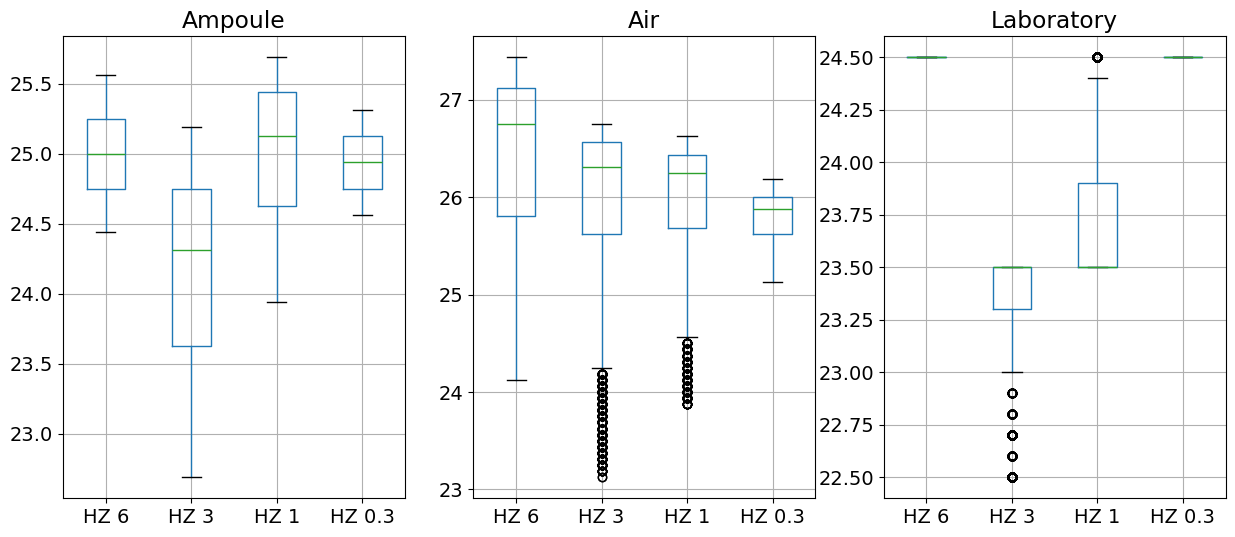

In [188]:
HZ6, _ = CFG.dataset_6HZ()
HZ3, _ = CFG.dataset_3HZ()
HZ1, _ = CFG.dataset_1HZ()
HZ03, _ = CFG.dataset_03HZ()


temp = pd.DataFrame({'HZ 6' : HZ6['temperature'], 
        'HZ 3' : HZ3['temperature'], 
        'HZ 1' : HZ1['temperature'], 
        'HZ 0.3' : HZ03['temperature']})

air_temp = pd.DataFrame({'HZ 6' : HZ6['air_temp'], 
        'HZ 3' : HZ3['air_temp'], 
        'HZ 1' : HZ1['air_temp'], 
        'HZ 0.3' : HZ03['air_temp']})

nivel = pd.DataFrame({'HZ 6' : HZ6['nivel_t'], 
        'HZ 3' : HZ3['nivel_t'], 
        'HZ 1' : HZ1['nivel_t'], 
        'HZ 0.3' : HZ03['nivel_t']})

fig = plt.figure(figsize=(15,6))
ax1 =fig.add_subplot(1,3,1)
temp.boxplot(ax = ax1)
ax1.set_title('Ampoule')
ax2 =fig.add_subplot(1,3,2)
air_temp.boxplot(ax = ax2)
ax2.set_title('Air')
ax3 =fig.add_subplot(1,3,3)
nivel.boxplot(ax = ax3)
ax3.set_title('Laboratory')
plt.show()

In [509]:
train, test = CFG.dataset_03HZ()

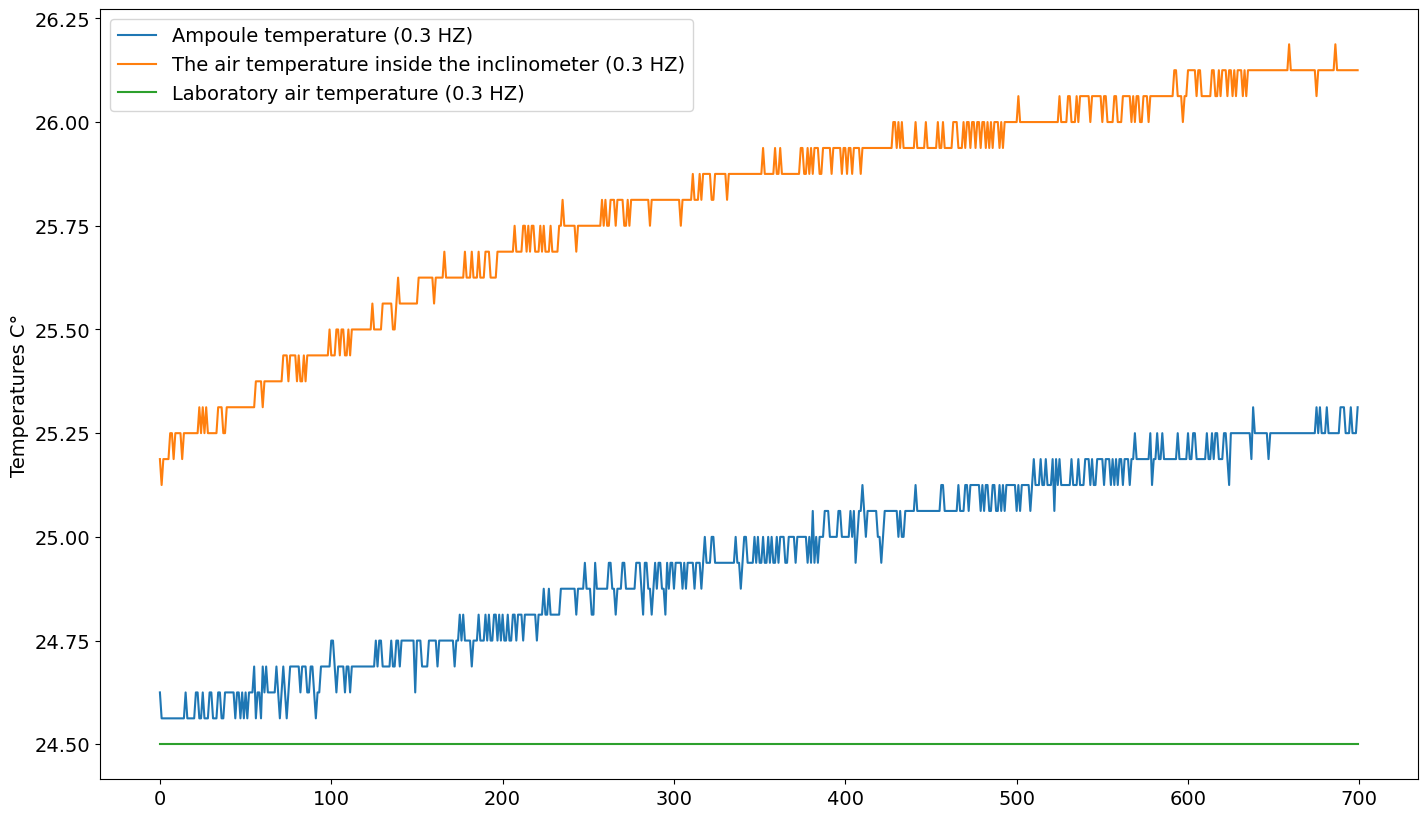

In [510]:
fig,ax = plt.subplots(figsize=(17,10))
plt.rc('font', size=14)          
lns1=ax.plot(train.index,train[['temperature','air_temp', 'nivel_t']])

ax.set_ylabel('Temperatures С°', fontsize=14)

ax.legend(lns1,['Ampoule temperature (0.3 HZ)',
                'The air temperature inside the inclinometer (0.3 HZ)',
                'Laboratory air temperature (0.3 HZ)'],fontsize=14)

plt.show()

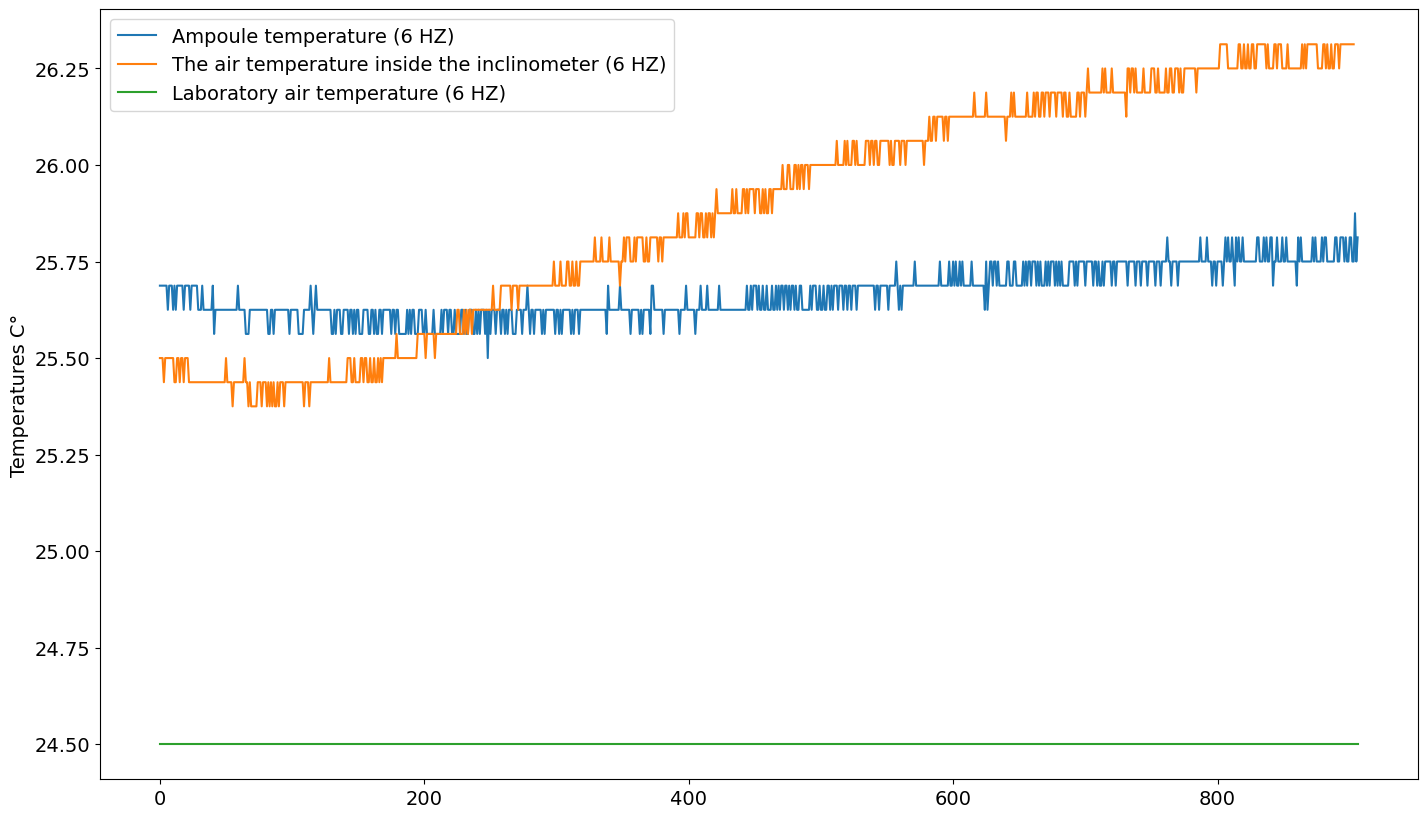

In [511]:
fig,ax = plt.subplots(figsize=(17,10))
plt.rc('font', size=14)          
lns1=ax.plot(test.index,test[['temperature','air_temp', 'nivel_t']])

ax.set_ylabel('Temperatures С°', fontsize=14)

ax.legend(lns1,['Ampoule temperature (6 HZ)',
                'The air temperature inside the inclinometer (6 HZ)',
                'Laboratory air temperature (6 HZ)'],fontsize=14)

plt.show()

<Axes: >

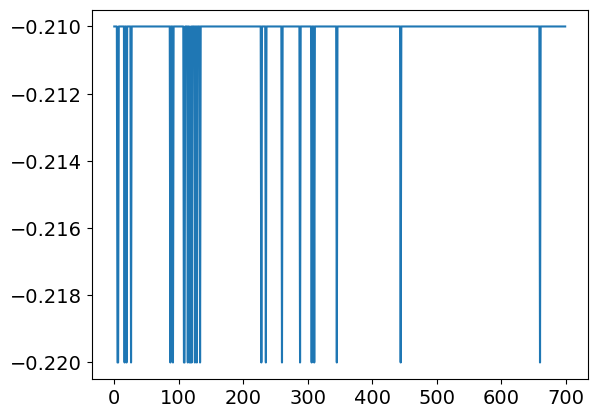

In [512]:
train[CFG.TARGET].plot()

<Axes: >

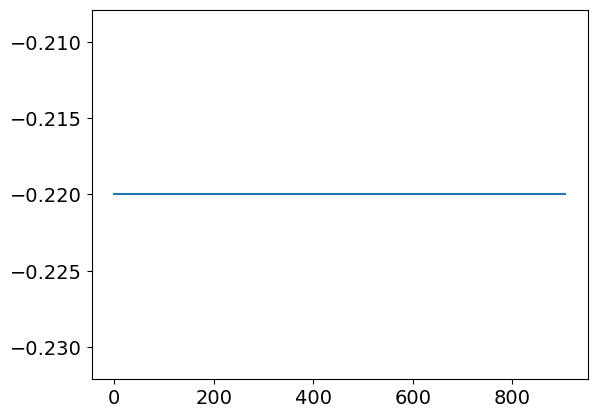

In [513]:
test[CFG.TARGET].plot()

In [514]:
train = train.loc[(train['watch_indicator'] != 'False') &
                (train['watch_indicator'] != 'None')]
train = train.drop(columns=['time', 'watch_indicator', 'nivel_t', 'nivel_x'])

test = test.loc[(test['watch_indicator'] != 'False') &
                (test['watch_indicator'] != 'None')]
test = test.drop(columns=['time', 'watch_indicator', 'nivel_t', 'nivel_x'])


In [515]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)







train['center_bubbles_px'] = train['center_bubbles_px'].loc[(train['center_bubbles_px'] > -5) & (train['center_bubbles_px'] < 10)]
test['center_bubbles_px'] = test['center_bubbles_px'].loc[(test['center_bubbles_px'] > -5) & (test['center_bubbles_px'] < 10)]

for i in train.columns:
    if i not in [CFG.TARGET, 'temperature', 'air_temp','center_bubbles_px']:
        train[i] = train[i].loc[np.abs(train[i]) < np.abs(train[i].median())*1.25]
        test[i] = test[i].loc[np.abs(test[i]) < np.abs(test[i].median())*1.25]


for i in train.columns:
    if i not in [CFG.TARGET, 'temperature', 'air_temp']:
        train[i] = train[i].interpolate(method='nearest', limit_direction='forward')
        test[i] = test[i].interpolate(method='nearest', limit_direction='forward')

In [516]:
train['100'].median()

105.0

In [517]:
# (train['100'].loc[(np.abs(train['100']) < np.abs(train['100'].median())*1.25)]).plot()

<Axes: >

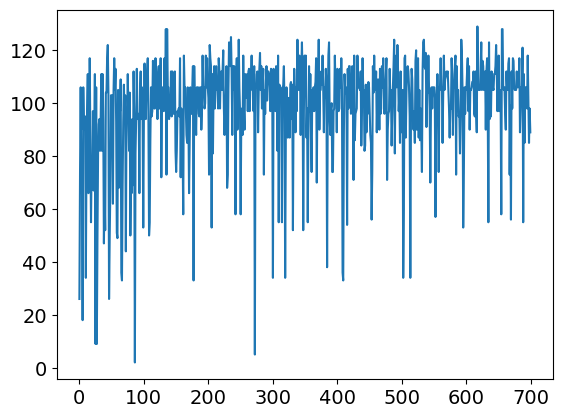

In [518]:
train['100'].plot()

In [519]:
# def agg_features(df, suffix=''):
#     X = pd.DataFrame()    
#     X[suffix+"median"] = df.median(axis=1)
#     X[suffix+"mean"] = df.mean(axis=1)
#     X[suffix+"std"] = df.std(axis=1)
#     X[suffix+"max"] = df.max(axis=1)
#     X[suffix+"min"] = df.min(axis=1)
#     X["length"] = np.sqrt(df['1']**2 - df['center_bubbles_px']**2)
#     return X

In [520]:
# train = train.join(agg_features(train), how='left')
# test = test.join(agg_features(test), how='left')

In [521]:
# STEP = 35

# for i in train.columns:
#     # if i not in [CFG.TARGET, 'temperature']:
#     if i not in [CFG.TARGET, 'temperature', 'air_temp']:
#         train[i] = train[i].rolling(STEP).median()
#         train[i] = train[i][STEP:]
#         test[i] = test[i].rolling(STEP).median()
#         test[i] = test[i][STEP:]

In [522]:
train.isna().sum()

center_bubbles_px    0
nivel_y              0
temperature          0
1                    0
2                    0
                    ..
97                   0
98                   0
99                   0
100                  0
air_temp             0
Length: 104, dtype: int64

In [523]:

# train = train.fillna(0.0)
# test = test.fillna(0.0)
train.dropna(inplace=True)
test.dropna(inplace=True)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)



# columns = ['center_bubbles_px', 'temperature', 'air_temp', CFG.TARGET]

# train = train[columns]
# test = test[columns]

features = train.drop([CFG.TARGET], axis=1)
target = train[CFG.TARGET]

<Axes: >

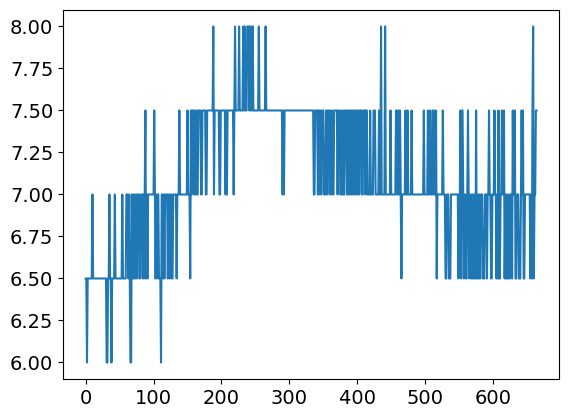

In [524]:
features['center_bubbles_px'].plot()

# Linear Regression for Ct

slope (95%): 0.224952 +/- 0.148581
intercept (95%): 1.483855 +/- 3.709090


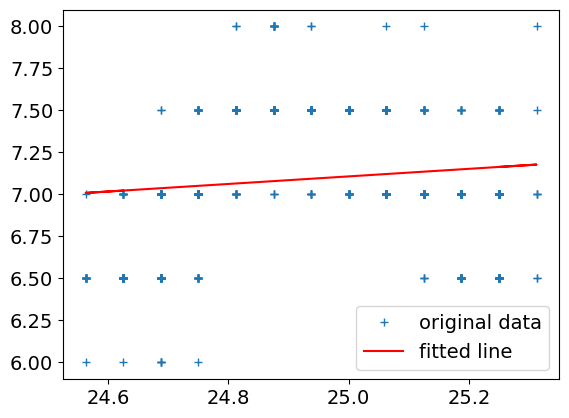

In [525]:
from scipy import stats

res = stats.linregress(features['temperature'], features['center_bubbles_px'])

from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df))

ts = tinv(0.05, len(features['temperature'])-2)
print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")

print(f"intercept (95%): {res.intercept:.6f}"
      f" +/- {ts*res.intercept_stderr:.6f}")
# print(f"fitted {res.intercept + res.slope*features['temperature']}")
plt.plot(features['temperature'], features['center_bubbles_px'], '+', label='original data')
plt.plot(features['temperature'], res.intercept + res.slope*features['temperature'], 'r', label='fitted line')
plt.legend()
plt.show()

In [526]:
df_cf = train.copy()

for i in df_cf.columns:
    if i not in [CFG.TARGET, 'temperature', 'air_temp']:
        res = stats.linregress(df_cf['temperature'], df_cf[i])
        df_cf[i] -= res.intercept + res.slope*df_cf['temperature']

In [527]:
df_cf.head()

,center_bubbles_px,nivel_y,temperature,1,2,3,4,5,6,7,...,92,93,94,95,96,97,98,99,100,air_temp
0,-0.523306,-0.21,24.6250,-0.713159,-0.747494,-0.842134,-1.131987,-1.896929,-3.407374,-3.296511,...,-5.674390,0.750420,-5.075221,-3.026130,-6.858766,0.089179,-2.084825,0.477365,-1.698961,25.2500
1,-0.509246,-0.21,24.5625,-0.523084,-0.551526,-0.650602,-0.937603,-1.701065,-3.253395,-2.130636,...,-11.661993,-0.732032,-6.196608,-6.540155,-9.570369,-0.741471,-2.866955,3.435452,1.323921,25.2500
2,-1.009246,-0.21,24.5625,-1.523084,-1.551526,-1.650602,-1.937603,-1.701065,-2.253395,-2.130636,...,-16.661993,-20.732032,-26.196608,-18.540155,-21.570369,-14.741471,-16.866955,-8.564548,-10.676079,25.2500
3,-0.509246,-0.21,24.5625,-0.523084,-0.551526,-0.650602,-0.937603,-0.701065,-2.253395,-3.130636,...,2.338007,3.267968,-2.196608,-2.540155,-5.570369,2.258529,0.133045,3.435452,1.323921,25.2500
4,-0.523306,-0.21,24.6250,-0.713159,-0.747494,1.157866,3.868013,4.103071,4.592626,4.703489,...,2.325610,2.750420,38.924779,24.973870,21.141234,22.089179,19.915175,19.477365,17.301039,25.3125


In [528]:
features_l = df_cf.drop([CFG.TARGET], axis=1)
target_l = df_cf[CFG.TARGET]

In [529]:
np.sqrt(mean_squared_error(target_l, features_l['center_bubbles_px']))

0.4521582568831833

In [530]:
dif_l1 = target_l - (features_l['center_bubbles_px'])
dif_l1.mean()

-0.21030075187969946

# Multiple Linear Regression

In [343]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(features, target-.005)

In [531]:
pred_l = reg.predict(test.drop(columns=CFG.TARGET))

In [532]:
np.sqrt(mean_squared_error(test[CFG.TARGET], pred_l))

0.010796392118601212

In [533]:
dif_l = test[CFG.TARGET] - (pred_l)
dif_l.mean()

0.010470250790290627

# Cat

In [402]:
features_train, features_test, target_train, target_test = \
    train_test_split(features, target-.005, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [421]:
def build_catboost(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 0.01, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', .1, 1., log=True),
        'random_strength': trial.suggest_float('random_strength', .1, 1., log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', .1, 1., log=True),
        'bootstrap_type':'Bayesian',
        'task_type': 'GPU',
        'loss_function':'RMSE',
        'eval_metric' : 'RMSE',
    }

    model = CatBoostRegressor(**params, silent=True, random_state=CFG.RANDOM_STATE)
    cv_data = cv(
        Pool(features_train, target_train),
        model.get_params(),
        verbose=False
    )
    return np.min(cv_data['test-RMSE-mean'])

In [422]:
study = optuna.create_study(direction="minimize")
study.optimize(build_catboost, n_trials=10)

[I 2024-09-17 13:35:18,320] A new study created in memory with name: no-name-ae27eb88-201d-465b-918b-620d8a917134


Training on fold [0/3]
bestTest = 0.1624472951
bestIteration = 999
Training on fold [1/3]
bestTest = 0.1625175332
bestIteration = 999
Training on fold [2/3]


[I 2024-09-17 13:36:17,897] Trial 0 finished with value: 0.1624465728527488 and parameters: {'learning_rate': 0.00031407632558410394, 'depth': 10, 'l2_leaf_reg': 0.4448416192490385, 'random_strength': 0.12908175294655957, 'bagging_temperature': 0.8751717703627029}. Best is trial 0 with value: 0.1624465728527488.


bestTest = 0.1623748902
bestIteration = 999
Training on fold [0/3]
bestTest = 0.04646676512
bestIteration = 999
Training on fold [1/3]
bestTest = 0.04654458203
bestIteration = 999
Training on fold [2/3]


[I 2024-09-17 13:37:10,389] Trial 1 finished with value: 0.046470433191063705 and parameters: {'learning_rate': 0.0015763059690931138, 'depth': 9, 'l2_leaf_reg': 0.5373980808675022, 'random_strength': 0.3365302145470988, 'bagging_temperature': 0.5704693728836123}. Best is trial 1 with value: 0.046470433191063705.


bestTest = 0.04639995242
bestIteration = 999
Training on fold [0/3]
bestTest = 0.1790394951
bestIteration = 999
Training on fold [1/3]
bestTest = 0.1791069714
bestIteration = 999
Training on fold [2/3]


[I 2024-09-17 13:37:32,984] Trial 2 finished with value: 0.17903669027155225 and parameters: {'learning_rate': 0.000215903908242288, 'depth': 2, 'l2_leaf_reg': 0.10141748642241045, 'random_strength': 0.29584346494659947, 'bagging_temperature': 0.10792360741529582}. Best is trial 1 with value: 0.046470433191063705.


bestTest = 0.1789636044
bestIteration = 999
Training on fold [0/3]
bestTest = 0.2170352458
bestIteration = 999
Training on fold [1/3]
bestTest = 0.2170880529
bestIteration = 999
Training on fold [2/3]


[I 2024-09-17 13:38:09,038] Trial 3 finished with value: 0.21702871335028992 and parameters: {'learning_rate': 2.3393273873385363e-05, 'depth': 7, 'l2_leaf_reg': 0.32310680613007337, 'random_strength': 0.6453949145890232, 'bagging_temperature': 0.8618908364604712}. Best is trial 1 with value: 0.046470433191063705.


bestTest = 0.2169628413
bestIteration = 999
Training on fold [0/3]
bestTest = 0.1819170423
bestIteration = 999
Training on fold [1/3]
bestTest = 0.1819843754
bestIteration = 999
Training on fold [2/3]


[I 2024-09-17 13:38:33,445] Trial 4 finished with value: 0.18191466425215227 and parameters: {'learning_rate': 0.00020002178257465575, 'depth': 3, 'l2_leaf_reg': 0.15382749922501857, 'random_strength': 0.5572811346268911, 'bagging_temperature': 0.9919363815661115}. Best is trial 1 with value: 0.046470433191063705.


bestTest = 0.181842575
bestIteration = 999
Training on fold [0/3]
bestTest = 0.04772662264
bestIteration = 999
Training on fold [1/3]
bestTest = 0.04784478613
bestIteration = 999
Training on fold [2/3]


[I 2024-09-17 13:39:15,624] Trial 5 finished with value: 0.04775227956739403 and parameters: {'learning_rate': 0.0015467360261630827, 'depth': 8, 'l2_leaf_reg': 0.27422141193020777, 'random_strength': 0.24816822209040504, 'bagging_temperature': 0.3296185921603228}. Best is trial 1 with value: 0.046470433191063705.


bestTest = 0.04768542993
bestIteration = 999
Training on fold [0/3]
bestTest = 0.2194675194
bestIteration = 999
Training on fold [1/3]
bestTest = 0.2195192486
bestIteration = 999
Training on fold [2/3]


[I 2024-09-17 13:39:50,179] Trial 6 finished with value: 0.21946072645861378 and parameters: {'learning_rate': 1.2227433964876148e-05, 'depth': 7, 'l2_leaf_reg': 0.6533503311464296, 'random_strength': 0.3162399340249274, 'bagging_temperature': 0.16880774718649627}. Best is trial 1 with value: 0.046470433191063705.


bestTest = 0.2193954113
bestIteration = 999
Training on fold [0/3]
bestTest = 0.003842283197
bestIteration = 968
Training on fold [1/3]
bestTest = 0.003909851872
bestIteration = 999
Training on fold [2/3]


[I 2024-09-17 13:40:13,632] Trial 7 finished with value: 0.003904868638378998 and parameters: {'learning_rate': 0.008212690770227415, 'depth': 3, 'l2_leaf_reg': 0.35592385647570657, 'random_strength': 0.9937444240824781, 'bagging_temperature': 0.1915764351982925}. Best is trial 7 with value: 0.003904868638378998.


bestTest = 0.00396186661
bestIteration = 998
Training on fold [0/3]
bestTest = 0.01786699255
bestIteration = 999
Training on fold [1/3]
bestTest = 0.01794626983
bestIteration = 999
Training on fold [2/3]


[I 2024-09-17 13:41:03,491] Trial 8 finished with value: 0.01788219529879219 and parameters: {'learning_rate': 0.002571085534172423, 'depth': 9, 'l2_leaf_reg': 0.42631286056822143, 'random_strength': 0.21573876048496446, 'bagging_temperature': 0.3800727945922454}. Best is trial 7 with value: 0.003904868638378998.


bestTest = 0.01783332352
bestIteration = 999
Training on fold [0/3]
bestTest = 0.2111366195
bestIteration = 999
Training on fold [1/3]
bestTest = 0.2111917132
bestIteration = 999
Training on fold [2/3]


[I 2024-09-17 13:41:24,986] Trial 9 finished with value: 0.21113065332441253 and parameters: {'learning_rate': 5.092921982136511e-05, 'depth': 2, 'l2_leaf_reg': 0.2898315688558232, 'random_strength': 0.3958196714925118, 'bagging_temperature': 0.14886373874631445}. Best is trial 7 with value: 0.003904868638378998.


bestTest = 0.2110636273
bestIteration = 999


In [423]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.008212690770227415, 'depth': 3, 'l2_leaf_reg': 0.35592385647570657, 'random_strength': 0.9937444240824781, 'bagging_temperature': 0.1915764351982925}
Best RMSE: 0.003904868638378998


# CB
- Best hyperparameters: {'learning_rate': 0.00047203914766012094, 'depth': 7, 'l2_leaf_reg': 0.12405167415915808, 'random_strength': 0.6117918596087812, 'bagging_temperature': 0.11075605640527406}
- Best RMSE: 0.13195979643689015

# NON-CB
- Best hyperparameters: {'learning_rate': 0.008681151630685426, 'depth': 1, 'l2_leaf_reg': 0.3978744610671192, 'random_strength': 0.32718187893217754, 'bagging_temperature': 0.337077824517019}
- Best RMSE: 0.003096857994992059

In [424]:
rmses = []
preds = []
skf = KFold(n_splits=CFG.N_FOLDS)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train[CFG.TARGET])):
    print(f'### Fold {fold+1} Training ###')

    X_train = train.loc[train_idx, [c for c in train.columns if c not in [CFG.TARGET]]]
    y_train = train.loc[train_idx, CFG.TARGET]
    X_valid = train.loc[valid_idx, X_train.columns]
    y_valid = train.loc[valid_idx, CFG.TARGET]
    X_test = test[X_train.columns]



    X_train_pool = Pool(X_train, y_train)
    X_valid_pool = Pool(X_valid, y_valid)
    X_test_pool = Pool(X_test)


    model = CatBoostRegressor(
        loss_function='RMSE',
        learning_rate=0.008212690770227415,
        iterations=10000,
        depth=3,
        l2_leaf_reg=0.35592385647570657,
        random_strength=0.9937444240824781,
        bagging_temperature=0.1915764351982925,
        bootstrap_type='Bayesian',
        task_type='GPU',
        eval_metric='RMSE',
        grow_policy='Depthwise',
        od_type='IncToDec',
        random_seed=CFG.RANDOM_STATE,
        verbose=False
    )

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=500, early_stopping_rounds=200)

    pred_valid = model.predict(X_valid_pool)
    preds.append(model.predict(X_test_pool))

    rmse = mean_squared_error(y_valid, pred_valid)**.5
    rmses.append(rmse)
    
    del X_train, y_train, X_valid, y_valid, X_test
    gc.collect()

    print(f'Fold {fold+1} RMSE: {rmse:.5f}\n')

print(f'\nOverall RMSE: {np.median(rmse):.5f} +/- {np.std(rmse):.5f}')

### Fold 1 Training ###
0:	learn: 0.0045572	test: 0.0029775	best: 0.0029775 (0)	total: 5.76ms	remaining: 57.6s
bestTest = 0.001681128943
bestIteration = 172
Shrink model to first 173 iterations.
Fold 1 RMSE: 0.00168

### Fold 2 Training ###
0:	learn: 0.0045488	test: 0.0031930	best: 0.0031930 (0)	total: 6.73ms	remaining: 1m 7s
500:	learn: 0.0036603	test: 0.0019501	best: 0.0019493 (481)	total: 2.17s	remaining: 41.2s
bestTest = 0.001949256585
bestIteration = 481
Shrink model to first 482 iterations.
Fold 2 RMSE: 0.00195

### Fold 3 Training ###
0:	learn: 0.0045339	test: 0.0035481	best: 0.0035481 (0)	total: 5.81ms	remaining: 58.1s
bestTest = 0.002997180867
bestIteration = 203
Shrink model to first 204 iterations.
Fold 3 RMSE: 0.00300

### Fold 4 Training ###
0:	learn: 0.0045357	test: 0.0035115	best: 0.0035115 (0)	total: 5.76ms	remaining: 57.6s
bestTest = 0.003243247767
bestIteration = 249
Shrink model to first 250 iterations.
Fold 4 RMSE: 0.00324

### Fold 5 Training ###
0:	learn: 0.004482

In [425]:
model.save_model('model_temp_stable_1')

In [410]:
# model = CatBoostRegressor()
# model.load_model('model_temp_stable')

In [534]:
r = model.predict(test[train.columns])

In [535]:
np.sqrt(mean_squared_error(test[CFG.TARGET], r))

0.002658965655792317

In [536]:
dif = test[CFG.TARGET] - (r)
dif.mean()

-0.00234953041365377

# NN

In [359]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [360]:
features_train, features_test, target_train, target_test = \
    train_test_split(features, target-.005, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [361]:
def build_model():
    model_nn = Sequential()
    model_nn.add(Dense(32, activation='tanh'))
    model_nn.add(Dense(1))
    model_nn.compile(optimizer=Adam(), 
                    loss='mean_squared_error', 
                    metrics=[RootMeanSquaredError()])
    return model_nn

In [362]:
model_nn = build_model()

model_nn.fit(
    features_train,
    target_train,
    epochs=100
)

Epoch 1/100
108/108 [==============================] - 0s 495us/step - loss: 0.0200 - root_mean_squared_error: 0.1414
Epoch 2/100
108/108 [==============================] - 0s 598us/step - loss: 0.0021 - root_mean_squared_error: 0.0462
Epoch 3/100
108/108 [==============================] - 0s 626us/step - loss: 9.6077e-04 - root_mean_squared_error: 0.0310
Epoch 4/100
108/108 [==============================] - 0s 645us/step - loss: 5.8911e-04 - root_mean_squared_error: 0.0243
Epoch 5/100
108/108 [==============================] - 0s 654us/step - loss: 4.2779e-04 - root_mean_squared_error: 0.0207
Epoch 6/100
108/108 [==============================] - 0s 654us/step - loss: 3.3829e-04 - root_mean_squared_error: 0.0184
Epoch 7/100
108/108 [==============================] - 0s 645us/step - loss: 2.9193e-04 - root_mean_squared_error: 0.0171
Epoch 8/100
108/108 [==============================] - 0s 645us/step - loss: 2.6919e-04 - root_mean_squared_error: 0.0164
Epoch 9/100
108/108 [===========

In [537]:
test_nn = scaler.transform(test.drop(columns=CFG.TARGET))

In [368]:
ynew = model_nn.predict(test_nn)
class_probabilities = np.hstack((1-ynew, ynew))
pred = pd.DataFrame(ynew)

71/71 [==============================] - 0s 386us/step


In [369]:
np.sqrt(mean_squared_error(test[CFG.TARGET], pred))

0.7412083931456681

In [370]:
dif_nn = test[CFG.TARGET] - pred
dif_nn[0].mean()

-0.5490319529149386

In [386]:
def build_neural_network(hp):    
    model = Sequential()
    model.add(layers.Flatten())
    for i in range(hp.Int("num_layers", 1, 8)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=2, max_value=64, step=4),
                activation=hp.Choice("activation", ["tanh", "relu","relu6", "leaky_relu", "linear"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.35))
    model.add(layers.Dense(1))
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=[RootMeanSquaredError()]
    )
    return model

In [387]:
build_neural_network(keras_tuner.HyperParameters())

In [388]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_neural_network,
    objective=keras_tuner.Objective('val_root_mean_squared_error', 'min'),
    max_trials=20,
    executions_per_trial=3,
    overwrite=True,
)

In [389]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 64, 'step': 4, 'sampling': 'linear'}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'relu', 'relu6', 'leaky_relu', 'linear'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [390]:
X_train, X_val, y_train, y_val = \
    train_test_split(features_train, target_train, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [391]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Trial 20 Complete [00h 00m 37s]
val_root_mean_squared_error: 0.004587164148688316

Best val_root_mean_squared_error So Far: 0.0041986618501444655
Total elapsed time: 00h 12m 17s


In [392]:
best_NN = build_neural_network(tuner.get_best_hyperparameters()[0])

In [393]:
callback = EarlyStopping(monitor='loss', patience=100)

In [394]:
best_NN.fit(
    X_train,  
    y_train,
    epochs=10000,
    callbacks=[callback]
)

Epoch 1/10000
81/81 [==============================] - 0s 1ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402
Epoch 2/10000
81/81 [==============================] - 0s 1ms/step - loss: 2.2657e-05 - root_mean_squared_error: 0.0048
Epoch 3/10000
81/81 [==============================] - 0s 988us/step - loss: 2.2689e-05 - root_mean_squared_error: 0.0048
Epoch 4/10000
81/81 [==============================] - 0s 1ms/step - loss: 2.1829e-05 - root_mean_squared_error: 0.0047
Epoch 5/10000
81/81 [==============================] - 0s 1ms/step - loss: 2.2089e-05 - root_mean_squared_error: 0.0047
Epoch 6/10000
81/81 [==============================] - 0s 1000us/step - loss: 2.2200e-05 - root_mean_squared_error: 0.0047
Epoch 7/10000
81/81 [==============================] - 0s 1ms/step - loss: 2.2017e-05 - root_mean_squared_error: 0.0047
Epoch 8/10000
81/81 [==============================] - 0s 1ms/step - loss: 2.1656e-05 - root_mean_squared_error: 0.0047
Epoch 9/10000
81/81 [==================

In [395]:
model_nn.save('NN_model_1.keras')

In [396]:
# import keras
# best_NN = keras.models.load_model('NN_model.keras')

In [538]:
ynew = best_NN.predict(test_nn)
class_probabilities = np.hstack((1-ynew, ynew))
pred = pd.DataFrame(ynew)

23/23 [==============================] - 0s 818us/step


In [539]:
np.sqrt(mean_squared_error(test[CFG.TARGET], pred))

0.005030020508722927

In [540]:
dif_nn = test[CFG.TARGET] - pred
dif_nn[0].mean()

0.0037734735497961863

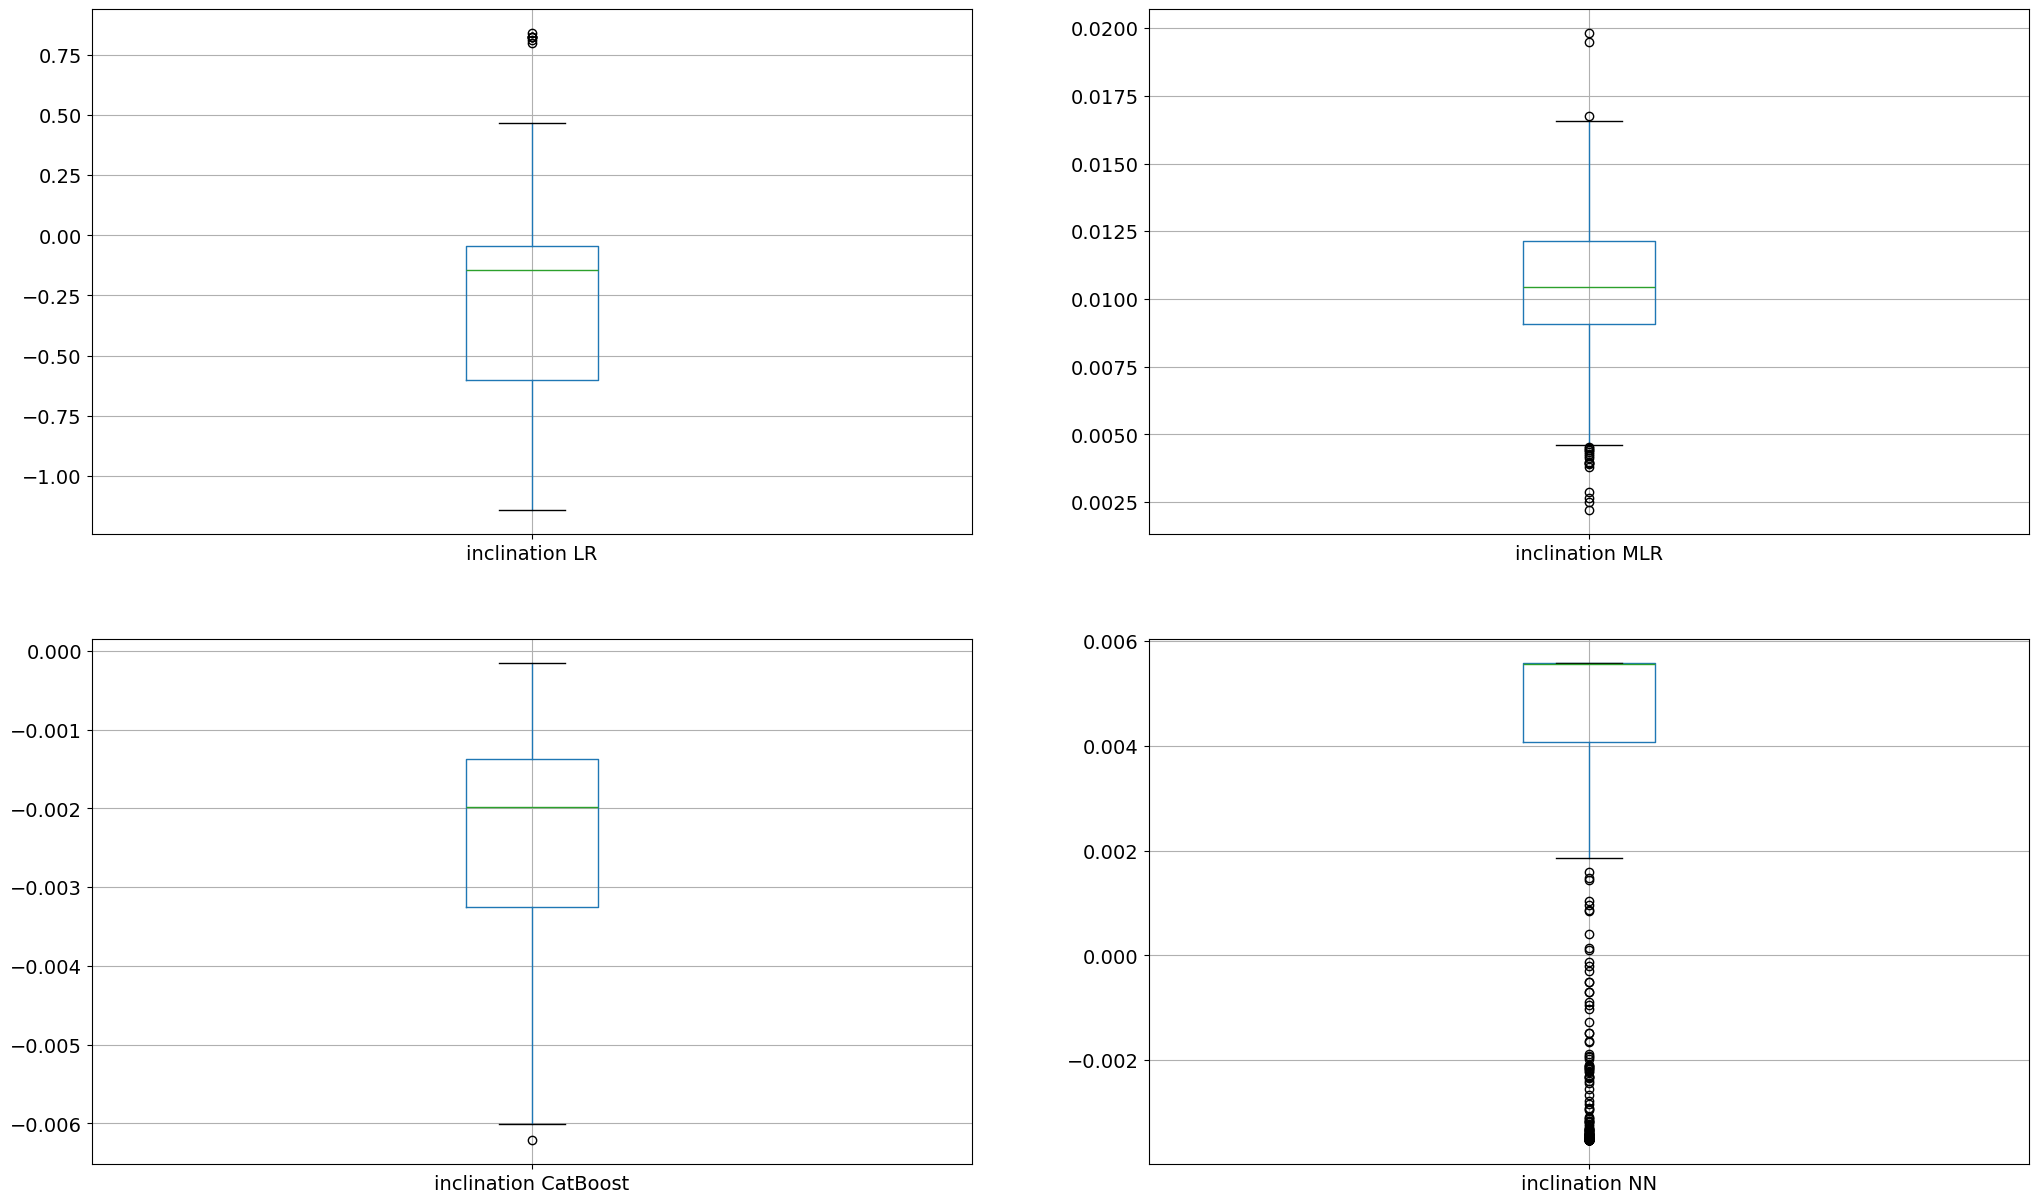

In [541]:
LR = pd.DataFrame({'inclination LR' : dif_l1})
MLR = pd.DataFrame({'inclination MLR' : dif_l})
CB = pd.DataFrame({'inclination CatBoost' : dif})
NN = pd.DataFrame({'inclination NN' : dif_nn[0],})

fig = plt.figure(figsize=(25,15))
ax1 =fig.add_subplot(2,2,1)
LR.boxplot(ax = ax1)
ax2 =fig.add_subplot(2,2,2)
MLR.boxplot(ax = ax2)
ax3 =fig.add_subplot(2,2,3)
CB.boxplot(ax = ax3)
ax4 =fig.add_subplot(2,2,4)
NN.boxplot(ax = ax4)
plt.show()